In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
def f(x):
    return 3*x**2 - 4*x + 5

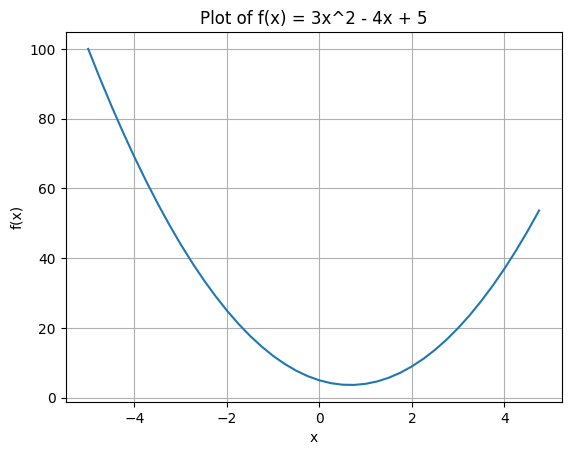

In [64]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.title("Plot of f(x) = 3x^2 - 4x + 5")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

In [65]:
h = 0.0001
x = -3
(f(x + h) - f(x))/h

-21.999700000066014

In [66]:
h = 0.0001

# Input Values
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [67]:
class Value:
    def __init__(self,x,_children=(),_op='',label=''):
        self.grad = 0.0
        self.data = x
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),"+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other),"*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [68]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [69]:
print(d.data)
print(d._prev)
print(d._op)    

4.0
{Value(data=-6.0), Value(data=10.0)}
+


In [70]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

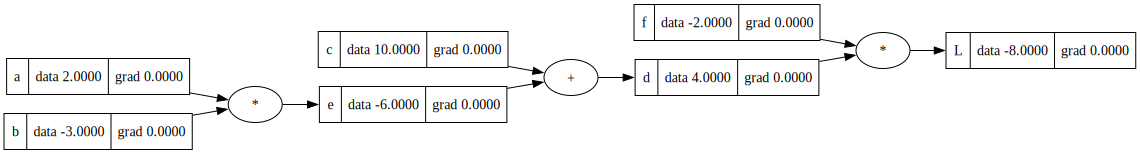

In [71]:
draw_dot(L)

In [72]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


In [73]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813564524, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


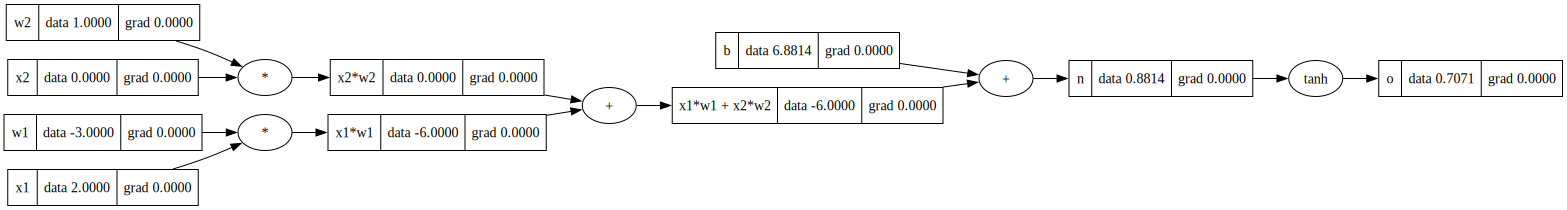

In [74]:
draw_dot(o)

In [75]:
o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

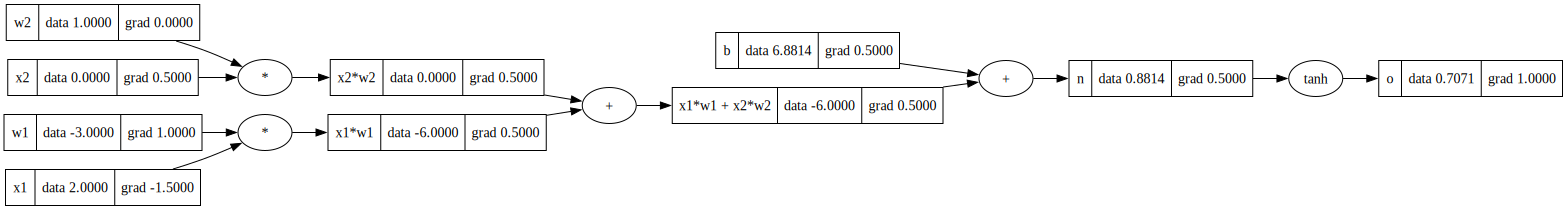

In [76]:
draw_dot(o)

In [77]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813564524, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


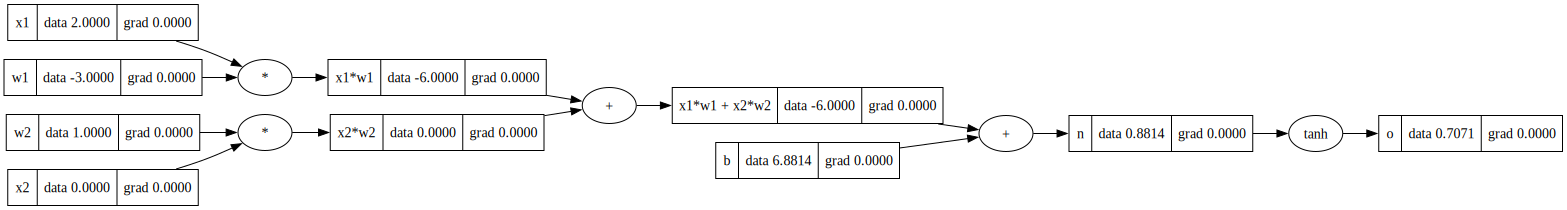

In [78]:
draw_dot(o)

In [79]:
o.grad = 1.0

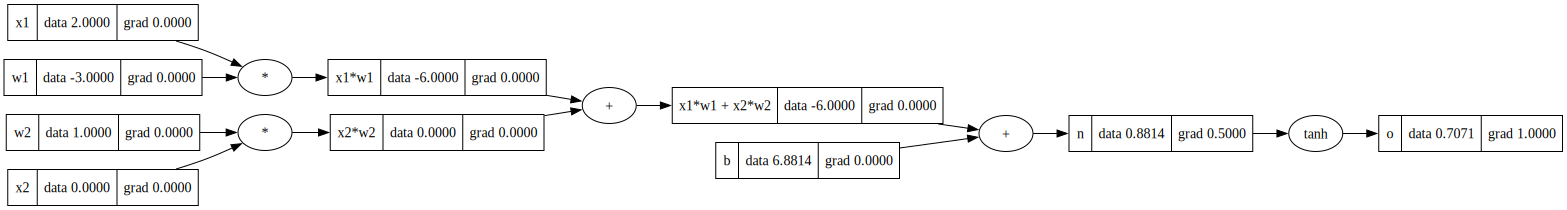

In [80]:
o._backward()
draw_dot(o)

In [81]:
n._backward()

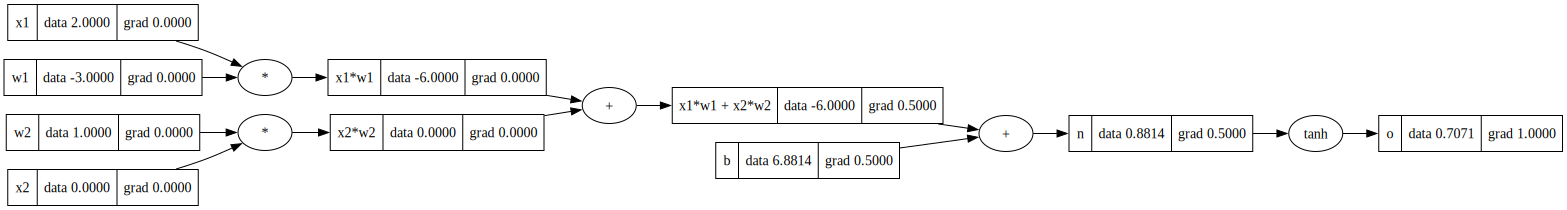

In [82]:
draw_dot(o)

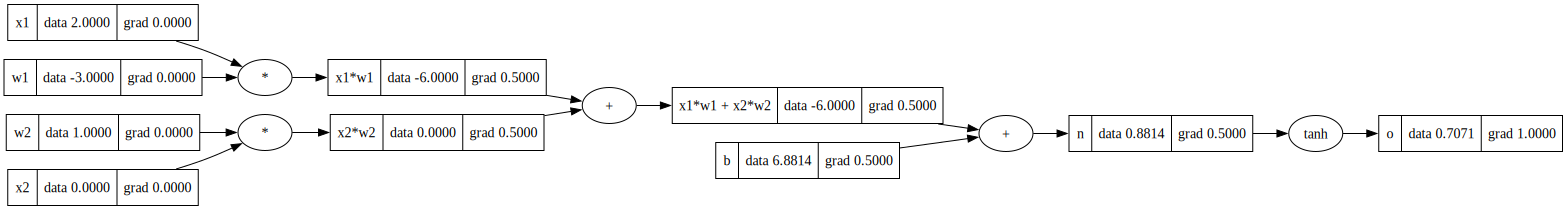

In [83]:
b._backward()
x1w1x2w2._backward()
draw_dot(o)

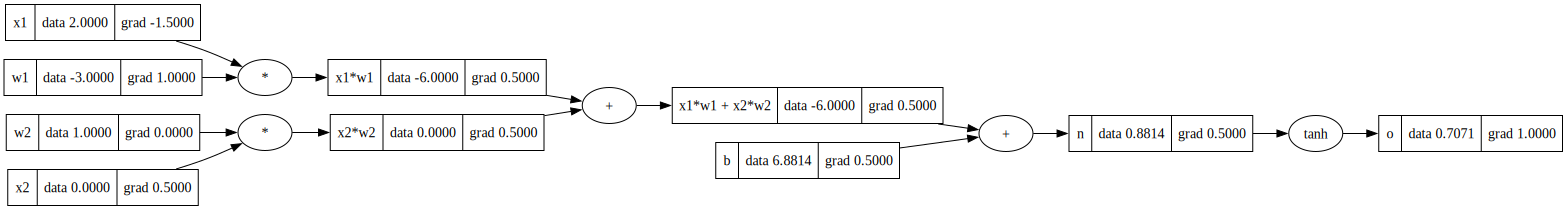

In [84]:
x2w2._backward()
x1w1._backward()    
draw_dot(o)

In [85]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo



[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8813564524),
 Value(data=0.8813564524000004),
 Value(data=0.7070982137729742)]

In [86]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813564524, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [87]:
o.grad = 1.0

In [88]:
def build_topo(o):
    topo = []
    visited = set()

    def dfs(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                dfs(child)
            topo.append(v)

    dfs(o)
    return topo

topo = build_topo(o)

In [89]:
for node in reversed(topo):
    node._backward()

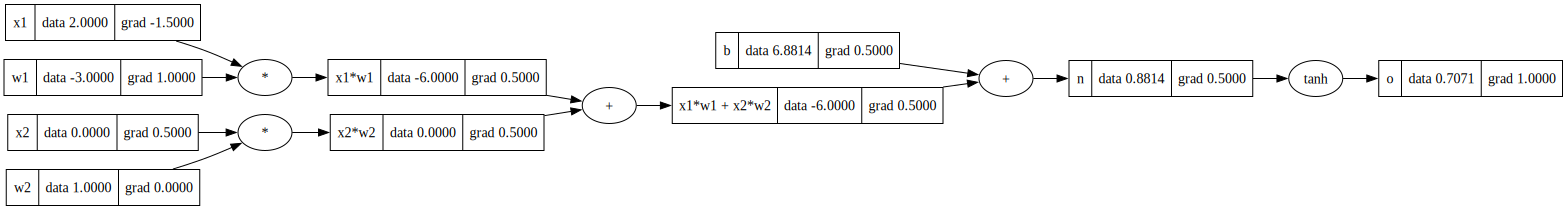

In [90]:
draw_dot(o)

In [91]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813564524, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


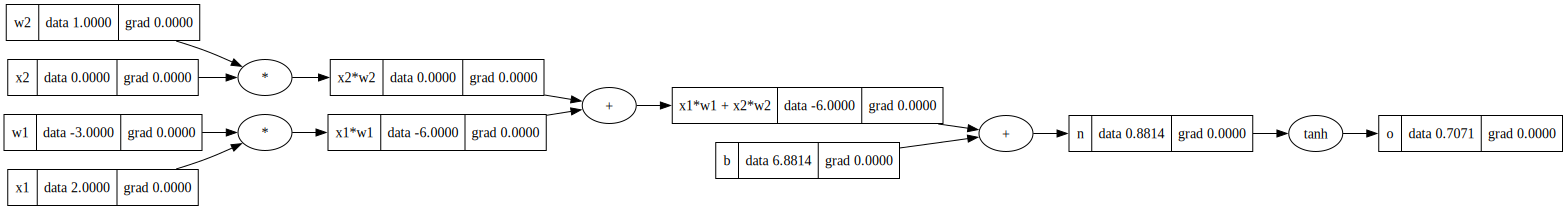

In [92]:
draw_dot(o)

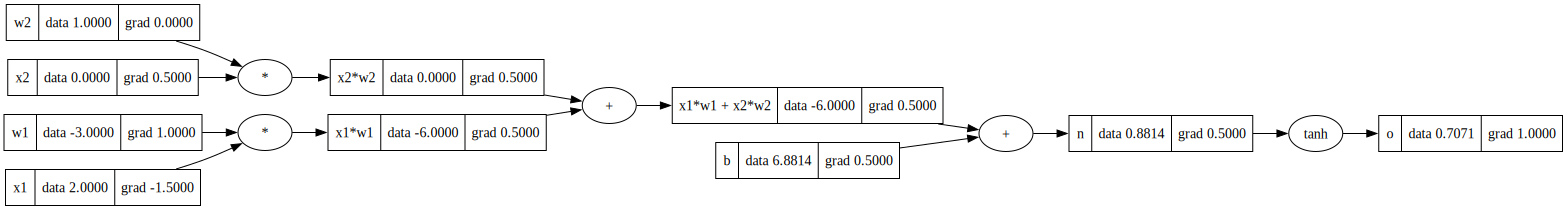

In [93]:
o.backward()
draw_dot(o)

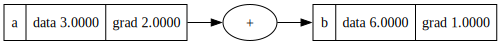

In [94]:
# o = tanh(n)
# do/dn = 1 - o**2
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


In [95]:
class Value:
    def __init__(self,x,_children=(),_op='',label=''):
        self.grad = 0.0
        self.data = x
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),"+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),"*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out
    
    def __sub__(self, other): #self - other
        return self + (other * -1)
            
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # division self/other
        return self * (other**-1)

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [96]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813564524, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


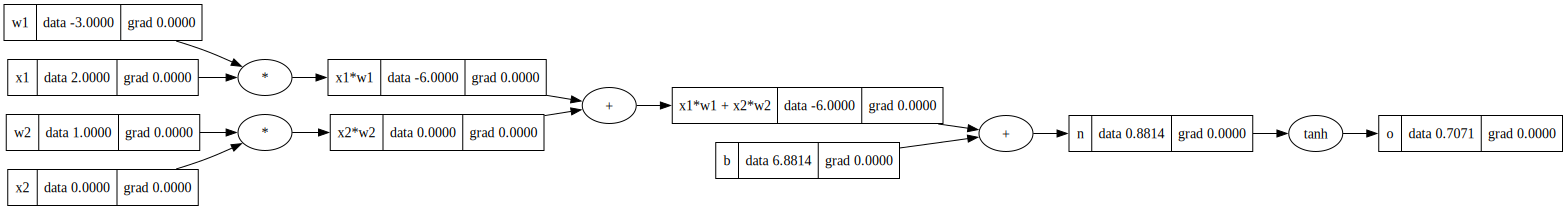

In [97]:
draw_dot(o)

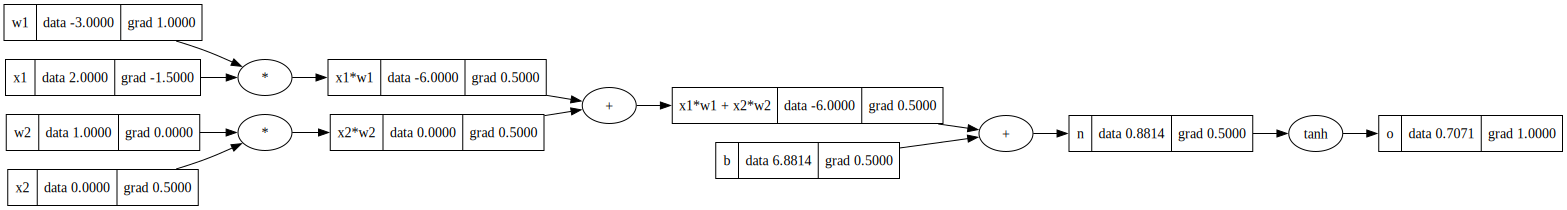

In [98]:
o.backward()
draw_dot(o)

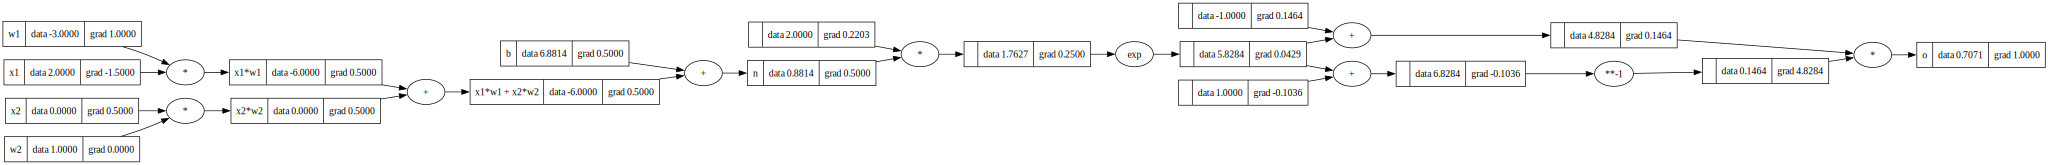

In [99]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [100]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w1*x1 + w2*x2 + ... + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [101]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

In [102]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [103]:
x = [2.0, 3.0, -1]
mlp = MLP(3, [4,4,1])
out = mlp(x)
out

Value(data=0.18006942824941696)

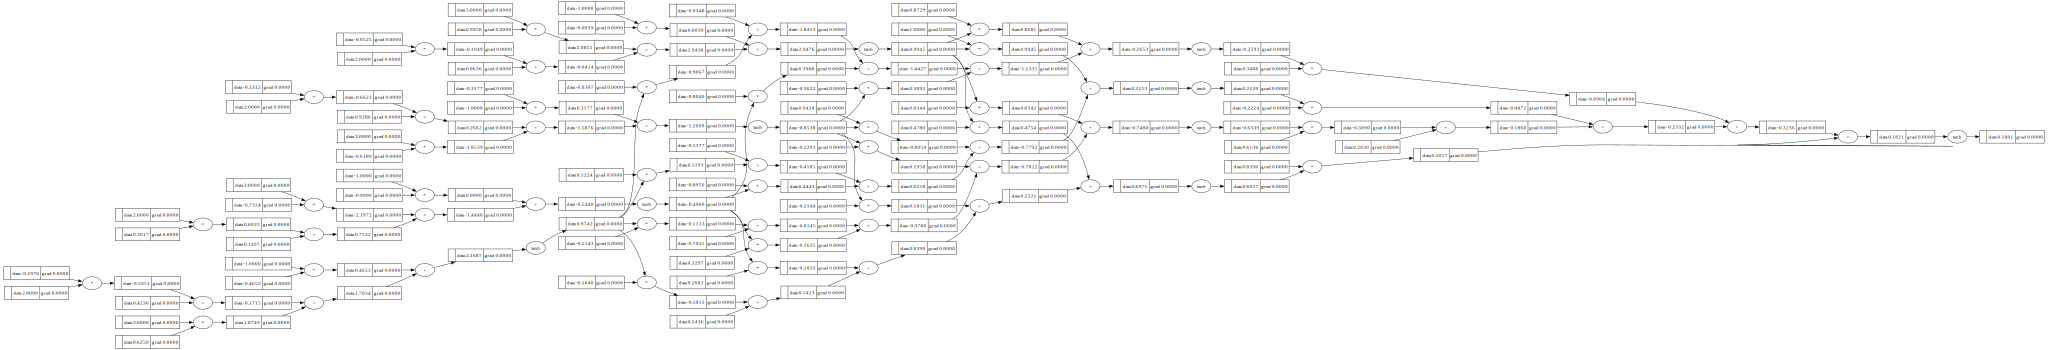

In [104]:
draw_dot(out)

In [105]:
xs = [[2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] 

In [106]:
y_pred = [mlp(x) for x in xs]
y_pred

[Value(data=0.18006942824941696),
 Value(data=-0.11265069437091013),
 Value(data=-0.03699306961153802),
 Value(data=-0.06074063077791131)]

In [107]:
loss = sum(((yout - ygt)**2 for yout, ygt in zip(y_pred, ys)), Value(0.0))
loss

Value(data=3.512227966450995)

In [108]:
loss.backward()

In [109]:
mlp.layers[0].neurons[0].w[0].grad

-0.41177403423262193

In [ ]:
draw_dot(loss)

In [111]:
mlp.parameters()

[Value(data=-0.29756581007896044),
 Value(data=0.6249623957622312),
 Value(data=-0.46528796460048216),
 Value(data=0.42360848957222674),
 Value(data=0.3017326503446738),
 Value(data=-0.7324066915200926),
 Value(data=-0.9000150358049592),
 Value(data=0.1497163886693802),
 Value(data=-0.3311652358769406),
 Value(data=-0.6179577238404674),
 Value(data=-0.3177195249250191),
 Value(data=0.9285778064950176),
 Value(data=-0.052473774314286015),
 Value(data=0.9950496533434883),
 Value(data=-0.003863715749390595),
 Value(data=0.06356630585747514),
 Value(data=-0.11427593831132121),
 Value(data=0.32969177416773787),
 Value(data=-0.229328248031071),
 Value(data=0.03441718616529066),
 Value(data=-0.7031476251539623),
 Value(data=0.12241772791727357),
 Value(data=-0.8956447138907799),
 Value(data=0.9428485545094489),
 Value(data=0.9999732230997576),
 Value(data=-0.5377138161703323),
 Value(data=-0.9306987601071135),
 Value(data=-0.8040464651527282),
 Value(data=-0.3621881547400325),
 Value(data=0.8

In [112]:
for p in mlp.parameters():
    p.data += -0.1 * p.grad

In [113]:
y_pred = [mlp(x) for x in xs]
loss = sum(((yout - ygt)**2 for yout, ygt in zip(y_pred, ys)), Value(0.0))
loss

Value(data=1.7484478152941814)

In [114]:
loss.backward()

In [115]:
for p in mlp.parameters():
    p.data += -0.1 * p.grad

In [116]:
y_pred = [mlp(x) for x in xs]
loss = sum(((yout - ygt)**2 for yout, ygt in zip(y_pred, ys)), Value(0.0))
loss

Value(data=0.28176109426919216)

In [119]:
for k in range(20):
  
  # forward pass
  y_pred = [mlp(x) for x in xs]
  loss = sum(((yout - ygt)**2 for yout, ygt in zip(y_pred, ys)), Value(0.0))

  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.28176109426919216
1 0.11035210405403459
2 0.07931087406030701
3 0.063053806872203
4 0.05258396389662905
5 0.04520619336014699
6 0.039700480580217225
7 0.03542130119830375
8 0.031992461243593256
9 0.029178995220376945
10 0.026826158201465597
11 0.0248276558501413
12 0.023107926440862542
13 0.02161170184414775
14 0.020297572528892686
15 0.019133867142284718
16 0.01809592721112139
17 0.017164253413125816
18 0.016323213502542813
19 0.015560122142681867


In [120]:
y_pred

[Value(data=0.965919170345234),
 Value(data=-0.9312957393983898),
 Value(data=-0.9374717882371435),
 Value(data=0.9240489203391413)]